# LSTM  + ElMO

En esta, rehacemos todo lo de ElMO pero usando nuestra nueva clase: ElMOModel

In [1]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/test_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Tengo que hacer dos cosas:

- Primero, convertir los tweets a secuencias de texto
- Luego, paddear las secuencias a cierta longitud (Keras necesita esto para poder paralelizar cálculo)

In [2]:
from hate.nn.preprocessing import Tokenizer

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
    "stem": False
}

tokenizer = Tokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

tokens_train = [tokenizer.tokenize(tweet) for tweet in df_train["text"].values]
tokens_dev = [tokenizer.tokenize(tweet) for tweet in df_dev["text"].values]
tokens_test = [tokenizer.tokenize(tweet) for tweet in df_test["text"].values]

Using TensorFlow backend.


Veamos las distribuciones de las longitudes de tokens

Media de longitud: train 22.91 dev 23.33 test 23.33


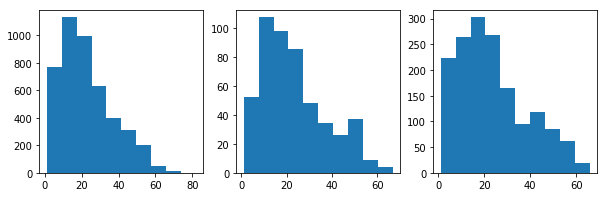

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,3)

train_lens = np.array([len(t) for t in tokens_train]) 
dev_lens = np.array([len(t) for t in tokens_dev])
test_lens = np.array([len(t) for t in tokens_test])

plt.subplot(1, 3, 1)

plt.hist(train_lens)

plt.subplot(1, 3, 2)
plt.hist(dev_lens)

plt.subplot(1, 3, 3)
plt.hist(test_lens)

print("Media de longitud: train {:.2f} dev {:.2f} test {:.2f}".format(train_lens.mean(), dev_lens.mean(), test_lens.mean()))


In [4]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

2019-01-20 05:42:14,577 INFO: char embedding size: 2637
2019-01-20 05:42:15,483 INFO: word embedding size: 185214
2019-01-20 05:42:24,867 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(185214, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(2637, 50, padding_idx=2634)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

Carguemos embeddings

In [15]:
from hate.nn import ElmoModel
from keras.optimizers import Adam
from keras.layers import CuDNNLSTM, CuDNNGRU

embedding_dim = 1024

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
    "stem": False
}

max_len = 60

X_train, y_train = df_train["text"], df_train["HS"]
X_dev, y_dev = df_dev["text"], df_dev["HS"]

model = ElmoModel(
    max_len=60, embedder=e, tokenize_args=tokenize_args,
    recursive_class=CuDNNLSTM,
)

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo_Input (InputLayer)      (None, 60, 1024)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               1181696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_elmo (Dense)           (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 1,214,721
Trainable params: 1,214,721
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
from keras.callbacks import ModelCheckpoint, BaseLogger

checkpointer = ModelCheckpoint('/tmp/elmo_15.h5', 
                               save_best_only=True, monitor='val_acc', verbose=1)
logger = BaseLogger(['accuracy'])

history_callback = model.fit(X_train, y_train, callbacks=[logger, checkpointer], 
                             validation_data=(X_dev, y_dev), epochs=40, batch_size=32)

2019-01-20 05:49:46,609 INFO: 71 batches, avg len: 62.0
2019-01-20 05:49:50,204 INFO: Finished 1000 sentences.
2019-01-20 05:49:53,727 INFO: Finished 2000 sentences.
2019-01-20 05:49:57,375 INFO: Finished 3000 sentences.
2019-01-20 05:50:01,084 INFO: Finished 4000 sentences.
2019-01-20 05:50:04,484 INFO: 8 batches, avg len: 62.0


Train on 4500 samples, validate on 500 samples
Epoch 1/40
4500/4500 [==============================] - 3s 764us/step - loss: 0.6711 - acc: 0.6113 - val_loss: 0.6380 - val_acc: 0.6200

Epoch 00001: val_acc improved from -inf to 0.62000, saving model to /tmp/elmo_15.h5
Epoch 2/40
4500/4500 [==============================] - 3s 580us/step - loss: 0.6227 - acc: 0.6533 - val_loss: 0.5976 - val_acc: 0.6700

Epoch 00002: val_acc improved from 0.62000 to 0.67000, saving model to /tmp/elmo_15.h5
Epoch 3/40
4500/4500 [==============================] - 3s 591us/step - loss: 0.5776 - acc: 0.7029 - val_loss: 0.5692 - val_acc: 0.7080

Epoch 00003: val_acc improved from 0.67000 to 0.70800, saving model to /tmp/elmo_15.h5
Epoch 4/40
4500/4500 [==============================] - 3s 591us/step - loss: 0.5526 - acc: 0.7238 - val_loss: 0.5256 - val_acc: 0.7320

Epoch 00004: val_acc improved from 0.70800 to 0.73200, saving model to /tmp/elmo_15.h5
Epoch 5/40
4500/4500 [==============================] - 3s 5

In [17]:
accuracies = history_callback.history['val_acc']

In [18]:
max(accuracies)

0.8039999995231628

In [19]:
from hate.utils import print_evaluation

model.load_weights(checkpointer.filepath)

print_evaluation(model, X_dev, y_dev)

2019-01-20 05:52:20,754 INFO: 8 batches, avg len: 62.0


500/500 [==============================] - 0s 238us/step


2019-01-20 05:52:23,990 INFO: 8 batches, avg len: 62.0


Loss        : 0.4543
Accuracy    : 0.8040
Precision   : 0.7808
Recall      : 0.7703
F1          : 0.7755


## Error Analysis

Vamos a ver los tweets con mayores errores

In [21]:
df_dev["proba"] = model.predict(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

conf_matrix[["pred_true", "pred_false"]]

2019-01-20 05:52:36,819 INFO: 8 batches, avg len: 62.0


,pred_true,pred_false
real,,
hs=1,171,51
hs=0,47,231


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [24]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.036916
21535,#VOX critica duramente a ⁦@pablocasado_⁩ “Les da la bienvenida como si fuera un cartel del welcome de #Carmena “ ¡Expulsión inmediata de moromierdas! https://t.co/HaySDibj2l,0.058543
22660,"En esta vida llamada spice girls, yo sería Ginger spice...les explico: No sería la negra, ni la güera ridícula, ni la deportista plana, y mucho menos la posona. Básicamente sería Ginger, por qué es la única que tuvo un éxito como solista. Bendiciones",0.079538
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.079712
24590,"SOMOS MUCHO MÁS DE LO QUE SUEÑAS SER PINCHÉ SUDACA CAGADO, y si no te gusta dime donde nos topamos pa reventarnos el hocico 1:1 @amarchesin1 https://t.co/vHHPBKS1AK",0.112416
23415,Exacto! #puralata #feminazis #HombreAbusado https://t.co/zTEvaftxcd,0.112994
20946,"Todo país debe supervisar al inmigrante, lamentablemente estos parásitos posiblemente cometieron delitos en #Venezuela pero la anarquía actual los complace para que sigan delinquiendo. https://t.co/d3VZA6PM0f",0.161875
24247,"La fundación Francisco Franco propone eliminar las concertinas de la valla de Ceuta, y untar con tocino de cerdo la frontera para evitar que los moros nos coman.",0.163080
23341,"Sudacas que votan a la derecha, que queres?",0.164530


- Qué onda la longitud de la secuencia?


In [25]:
pd.set_option('max_colwidth', 300)

false_positives[["text", "proba"]]


,text,proba
id,,
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.986203
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.974236
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.964992
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0.962298
21497,Talvez quede como zorra pero te lo mereces Socia😎,0.959186
21966,"escúchame ya me jodería jajajajajajajajajajajajajaja si pa ti enseñar es ser una guarra yo soy biennnn guarra, menos mal que no me respeto que si no... https://t.co/yt5fHp99b7",0.958371
21892,@saancisco Callate puta tu eres el traidor.,0.950176
20376,"Zorra tu abuela, imbécil.",0.949237
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.898630


## Submission

In [40]:
df_test["preds"] = (model.predict(df_test["text"]) >= 0.5).astype(int)
df_dev["preds"] = (model.predict(df_dev["text"]) >= 0.5).astype(int)

2019-01-20 06:09:45,537 INFO: 25 batches, avg len: 62.0
2019-01-20 06:09:49,195 INFO: Finished 1000 sentences.
2019-01-20 06:09:53,143 INFO: 8 batches, avg len: 62.0


In [41]:

dev_submission = "../../../submissions/dev/15_elmo.tsv" 

df_dev.to_csv("../../../submissions/dev/15_elmo.tsv", columns=["id", "preds"], sep='\t', quoting=csv.QUOTE_NONE)


/home/jmperez/.pyenv/versions/3.6.5/envs/hateval/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [42]:
df_dev.to_csv("es_a.tsv", columns=["id", "preds"], sep='\t', quoting=csv.QUOTE_NONE)


In [43]:
import zipfile

with zipfile.ZipFile("es_a.tsv.zip", 'w') as f:
    f.write('es_a.tsv')
